In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
import pandas as pd
import sys

import torch
import torchvision.models as models

from tensorflow import keras
from sklearn import model_selection
sys.path.append('../elpv-dataset/utils')
from elpv_reader import load_dataset
from PIL import Image

from numpy.typing import *
from typing import *

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout



# # # Resize the images to a consistent size // Originally all were 300x300. This just makes it eaier ot process
# image_size = (64, 64)
# images = [np.array(Image.fromarray(image).resize(image_size)) for image in images]


In [8]:

images, probs, types = load_dataset()

df = pd.DataFrame({'probs': probs, 'type': types})
ff_mc_indices = df[(df['probs'] == 0) & (df['type'] == 'mono')].index
ff_mc_images = images[ff_mc_indices]
ff_mc_probs = probs[ff_mc_indices]

print(images.dtype, images.shape)
print(probs.dtype, probs.shape)
print(types.dtype, types.shape)

uint8 (2624, 300, 300)
float64 (2624,)
<U4 (2624,)


In [7]:

from keras.applications import VGG19
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from sklearn.model_selection import train_test_split

# 1. Data Preprocessing
ff_images = ff_mc_images.astype(np.float32) / 255.0  # Normalize the images
ff_probs = ff_mc_probs.astype(np.float32)  # Ensure labels are float32

# Define degradation categories based on labels
def categorize_labels(labels):
    categories = []
    for label in labels:
        if label == 0 :
            categories.append(0)
        elif label <= 0.33:
            categories.append(1)
        elif label <= 0.66:
            categories.append(2)
        else:
            categories.append(3)
    return categories

# Convert labels to categorical (one-hot encoded) format
categories = categorize_labels(ff_probs)
labels = tf.one_hot(categories, depth=4)

# 2. Model Preparation
# Load pre-trained VGG-19 model without the top classification layer
base_model = VGG19(weights='imagenet', include_top=False)

# Add a custom classification layer with 3 output neurons for degradation categories
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the VGG model (if desired)
for layer in base_model.layers:
    layer.trainable = False


dataset = list(zip(ff_images, ff_probs))

train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Shuffle the dataset
np.random.shuffle(dataset)

# Calculate the split points based on the ratios
total_samples = len(dataset)
train_split = int(train_ratio * total_samples)
val_split = int((train_ratio + val_ratio) * total_samples)

# Split the dataset
train_data = dataset[:train_split]
val_data = dataset[train_split:val_split]
test_data = dataset[val_split:]

# Separate the images and labels
train_images, train_labels = zip(*train_data)
val_images, val_labels = zip(*val_data)
test_images, test_labels = zip(*test_data)


# 3. Training
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

# 4. Evaluation
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_acc}')


ValueError: Failed to find data adapter that can handle input: (<class 'tuple'> containing values of types {"<class 'numpy.ndarray'>"}), (<class 'tuple'> containing values of types {"<class 'numpy.float32'>"})

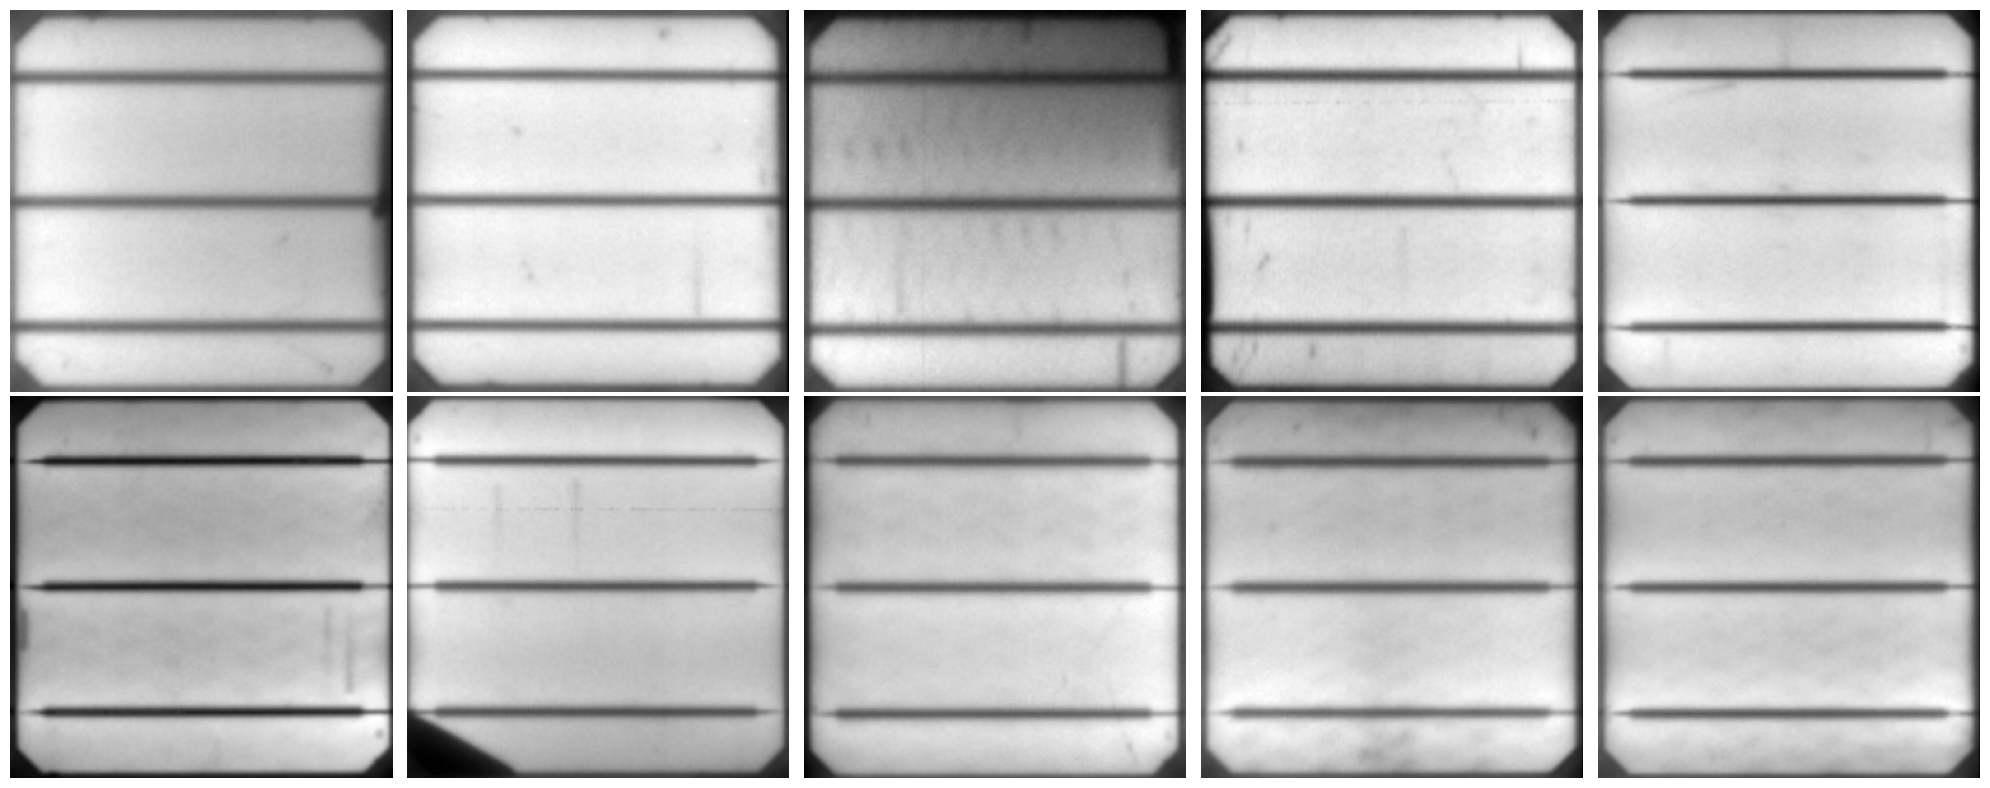

In [14]:
# Test first with mono and 0% degradation

import pandas as pd

df = pd.DataFrame({'probs': probs, 'type': types})
ff_mc_indices = df[(df['probs'] == 0) & (df['type'] == 'mono')].index
ff_mc_images = images[ff_mc_indices]
ff_mc_labels = probs[ff_mc_indices]

def plot_images(images, num_images):
    n = num_images
    cols = 5
    rows = n // cols + int((n % 5) > 0)
    fig, axes = plt.subplots(rows , cols, figsize=(20,4*rows))

    index = range(n)

    for i, ax in zip(index, axes.ravel()):
      ax.imshow(images[i], 'gray')
      ax.axis('off')

    plt.tight_layout()
    plt.show()

plot_images(ff_mc_images, 10)

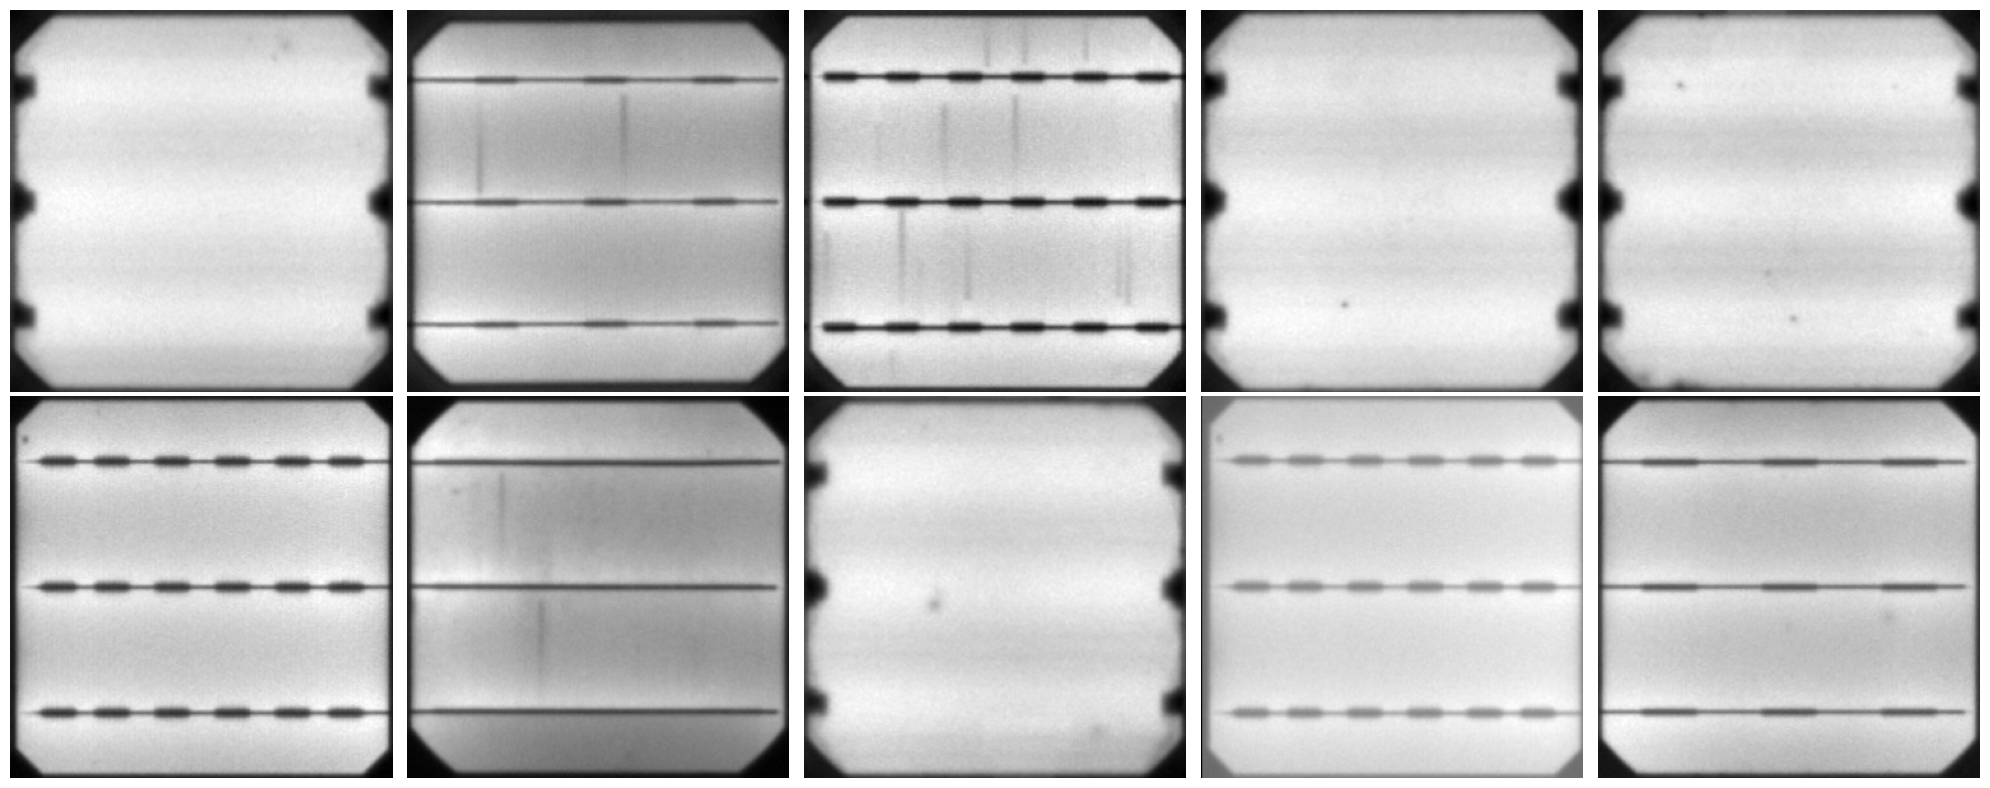

AttributeError: 'Sequential' object has no attribute 'fit'

In [18]:
import tensorflow as tf


# model is defined earlier 

# Compile the model
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy', 
#               metrics=['accuracy'])

ff_mc_images = images[ff_mc_indices]
ff_mc_labels = probs[ff_mc_indices]

dataset = list(zip(ff_mc_images, ff_mc_labels))

train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Shuffle the dataset
np.random.shuffle(dataset)

# Calculate the split points based on the ratios
total_samples = len(dataset)
train_split = int(train_ratio * total_samples)
val_split = int((train_ratio + val_ratio) * total_samples)

# Split the dataset
train_data = dataset[:train_split]
val_data = dataset[train_split:val_split]
test_data = dataset[val_split:]

# Separate the images and labels
train_images, train_labels = zip(*train_data)
val_images, val_labels = zip(*val_data)
test_images, test_labels = zip(*test_data)

plot_images(test_images, 10)


# Train the model
model.fit(train_images, train_labels, validation_data=(val_images, val_labels), epochs=10)

ff_mc_images = images[ff_mc_indices]
ff_mc_labels = probs[ff_mc_indices]

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_acc}')

# Predict new images
predictions = model.predict(test_images)

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np


ff_mc_images = images[ff_mc_indices]
ff_mc_labels = probs[ff_mc_indices]

dataset = list(zip(ff_mc_images, ff_mc_labels))

train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Shuffle the dataset
np.random.shuffle(dataset)

# Calculate the split points based on the ratios
total_samples = len(dataset)
train_split = int(train_ratio * total_samples)
val_split = int((train_ratio + val_ratio) * total_samples)

# Split the dataset
train_data = dataset[:train_split]
val_data = dataset[train_split:val_split]
test_data = dataset[val_split:]

# Separate the images and labels
train_images, train_labels = zip(*train_data)
val_images, val_labels = zip(*val_data)
test_images, test_labels = zip(*test_data)

train_images = np.array(train_images)
train_labels = np.array(train_labels)
val_images = np.array(val_images)
val_labels = np.array(val_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

print(val_images.shape)
print(test_images.shape)

# Reshape the images to match the expected input shape (300x300 pixels, 3 channels)
train_images = train_images.reshape(-1, 300, 300, 1)
val_images = val_images.reshape(-1, 300, 300, 1)
test_images = test_images.reshape(-1, 300, 300, 1)

# Normalize pixel values to the range [0, 1]
train_images = train_images / 255.0
val_images = val_images / 255.0
test_images = test_images / 255.0



model = Sequential()

model.add(Conv2D(16, (3, 3), 1, activation="relu", input_shape=(300, 300, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3, 3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(128, (3, 3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(256, (3, 3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(512, (3, 3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(512, activation="relu"))
model.add(Dense(4, activation="softmax"))  # 4 output classes for the specified ranges

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()


EPOCHS = 50
# hist = model.fit(train_images, train_labels, epochs=EPOCHS, validation_data=(val_images, val_labels))
hist = model.fit(train_images, train_labels, epochs=EPOCHS)


(118, 300, 300)
(59, 300, 300)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 149, 149, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPo

ValueError: in user code:

    File "/Users/salal/opt/anaconda3/envs/9517/lib/python3.7/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/Users/salal/opt/anaconda3/envs/9517/lib/python3.7/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/salal/opt/anaconda3/envs/9517/lib/python3.7/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/Users/salal/opt/anaconda3/envs/9517/lib/python3.7/site-packages/keras/engine/training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "/Users/salal/opt/anaconda3/envs/9517/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/salal/opt/anaconda3/envs/9517/lib/python3.7/site-packages/keras/engine/input_spec.py", line 278, in assert_input_compatibility
        f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Exception encountered when calling layer 'sequential_1' (type Sequential).
    
    Input 0 of layer "conv2d_6" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (None, 300, 300, 1)
    
    Call arguments received by layer 'sequential_1' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 300, 300, 1), dtype=float32)
      • training=True
      • mask=None
